In [1]:
import  os;
import  sys;
util_Path : str = os.path.join(os.path.join(os.path.pardir, "src"), "Utilities");
sys.path.append(util_Path);

import  colorsys;

import  torch;
import  matplotlib          as  mpl;
import  matplotlib.pyplot   as  plt;
import  seaborn;

import  FiniteDifference;

def Initialize_MPL() -> None:
    """
    This function initialize matplotlib's parameter so that the plots it generates are less ugly.
    This function has no arguments or return variables.
    """

    # Now... let's set up plot formatting.
    def scale_lightness(rgb, scale_l):
        # convert rgb to hls
        h, l, s = colorsys.rgb_to_hls(*rgb)

        # manipulate h, l, s values and return as rgb
        return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

    seaborn.set_context(context     = "paper");
    seaborn.set_style(  style       = "darkgrid");
    mpl.rcParams["lines.linewidth"] = 2;
    mpl.rcParams["axes.linewidth"]  = 1.5;
    mpl.rcParams["axes.edgecolor"]  = "black";
    mpl.rcParams["grid.color"]      = "gray";
    mpl.rcParams["grid.linestyle"]  = "dotted";
    mpl.rcParams["grid.linewidth"]  = .67;
    mpl.rcParams["xtick.labelsize"] = 10;
    mpl.rcParams["ytick.labelsize"] = 10;
    mpl.rcParams["axes.labelsize"]  = 11;
    mpl.rcParams["axes.titlesize"]  = 12;
    mpl.rcParams["axes.facecolor"]  = scale_lightness(mpl.colors.ColorConverter.to_rgb("lightgrey"), 1.15);

Initialize_MPL();

### Scalar valued test

Set up a function and it's derivative for testing.

In [2]:
def F(t : torch.Tensor) -> torch.Tensor:
    # Computes exp(sin(t^2))
    assert(len(t.shape) == 1);

    t2 : torch.Tensor = torch.multiply(t, t);
    return torch.exp(torch.sin(t2))



def dF_dt(t : torch.Tensor) -> torch.Tensor:
    # Computes (d/dt)exp(sin(t)) = exp(sin(t^2))cos(t^2)2t
    assert(len(t.shape) == 1);

    t2 : torch.Tensor = torch.multiply(t, t);
    return torch.multiply(torch.multiply(torch.exp(torch.sin(t2)), torch.cos(t2)), 2*t);



def d2F_dt2(t : torch.Tensor) -> torch.Tensor:
    # Computes (d^2/dt^2)exp(sin(t^2)) = exp(sin(t^2))cos(t^2)^2 (4t^2) - exp(sin(t^2))sin(t^2)(4t^2) + 2exp(sin(t^2))cos(t^2)
    assert(len(t.shape) == 1);

    t2          : torch.Tensor  = torch.multiply(t, t);
    sin_t2      : torch.Tensor  = torch.sin(t2);
    cos_t2      : torch.Tensor  = torch.cos(t2);
    exp_sin_t2  : torch.Tensor  = torch.exp(sin_t2);

    return torch.multiply(torch.multiply(exp_sin_t2, torch.multiply(cos_t2, cos_t2)), 4*t2) - torch.multiply(torch.multiply(exp_sin_t2, sin_t2), 4*t2) + 2*torch.multiply(exp_sin_t2, cos_t2);

In [ ]:
h                   : float         = 0.02;
t                   : torch.Tensor  = torch.arange(start = 0, end = 20, step = h);

Ft                  : torch.Tensor  = F(t).reshape(-1, 1);

dF_dt_True          : torch.Tensor  = dF_dt(t).reshape(-1, 1);
dF_dt_2_Predict     : torch.Tensor  = FiniteDifference.Derivative1_Order2(X = Ft, h = h);
dF_dt_4_Predict     : torch.Tensor  = FiniteDifference.Derivative1_Order4(X = Ft, h = h);

d2F_dt2_True        : torch.Tensor  = d2F_dt2(t).reshape(-1, 1);
d2F_dt2_2_Predict   : torch.Tensor  = FiniteDifference.Derivative2_Order2(X = Ft, h = h);
d2F_dt2_4_Predict   : torch.Tensor  = FiniteDifference.Derivative2_Order4(X = Ft, h = h);



In [ ]:
# First Derivative
plt.figure();
plt.plot(t,     dF_dt_True,         label = "True");
plt.plot(t,     dF_dt_2_Predict,    label = r"$\mathcal{O}(h^2)$ prediction");
plt.plot(t,     dF_dt_4_Predict,    label = r"$\mathcal{O}(h^4)$ prediction");

plt.title("First Derivative");
plt.legend();



# First Derivative Error
plt.figure();
plt.plot(t,     dF_dt_True - dF_dt_2_Predict,   label = r"$\mathcal{O}(h^2)$ error");
plt.plot(t,     dF_dt_True - dF_dt_4_Predict,   label = r"$\mathcal{O}(h^4)$ error");

plt.title("First Derivative Error");
plt.legend();



# Second Derivative
plt.figure();
plt.plot(t[-5:],     d2F_dt2_True[-5:],       label = "True");
plt.plot(t[-5:],     d2F_dt2_2_Predict[-5:],  label = r"$\mathcal{O}(h^2)$ prediction");
plt.plot(t[-5:],     d2F_dt2_4_Predict[-5:],  label = r"$\mathcal{O}(h^4)$ prediction");

plt.title("Second Derivative");
plt.legend();



# Second Derivative Error
plt.figure();
plt.plot(t[-5:],     (d2F_dt2_True - d2F_dt2_2_Predict)[-5:],  label = r"$\mathcal{O}(h^2)$ error");
plt.plot(t[-5:],     (d2F_dt2_True - d2F_dt2_4_Predict)[-5:],  label = r"$\mathcal{O}(h^4)$ error");

plt.title("Second Derivative Error");
plt.legend();

plt.show()

# Non-Uniform test

In [ ]:
# Set up a non-uniform grid.
import random;
h                   : float         = 0.01;
dh                  : float         = 0.005;
n_steps             : int           = round(20./h);
t                   : torch.Tensor  = torch.empty(n_steps, dtype = torch.float32);
t[0] = 0;
for i in range(1, 1000):
    hi  = h + dh*(random.random() - .5);
    t[i] = t[i - 1] + hi;


# Compute derivatives + their approximations.
Ft                  : torch.Tensor  = F(t).reshape(-1, 1);

dF_dt_True          : torch.Tensor  = dF_dt(t).reshape(-1, 1);
dF_dt_2_Predict     : torch.Tensor  = FiniteDifference.Derivative1_Order2_NonUniform(X = Ft, t_Grid = t);

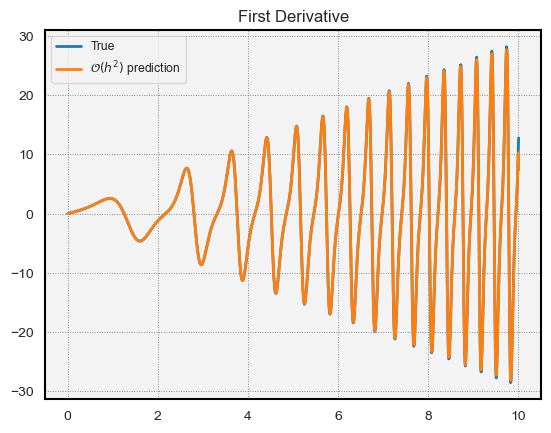

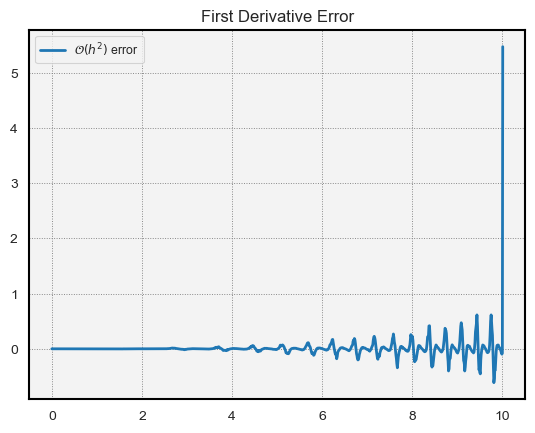

In [9]:
# First Derivative
plt.figure();
plt.plot(t,     dF_dt_True,         label = "True");
plt.plot(t,     dF_dt_2_Predict,    label = r"$\mathcal{O}(h^2)$ prediction");

plt.title("First Derivative");
plt.legend();


# First Derivative Error
plt.figure();
plt.plot(t,     dF_dt_True - dF_dt_2_Predict,   label = r"$\mathcal{O}(h^2)$ error");

plt.title("First Derivative Error");
plt.legend();
